In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
from tqdm.auto import tqdm
import os

import keras
from keras.layers import TimeDistributed, Conv2D, GlobalAveragePooling2D, Dense, MaxPooling2D, Input, LSTM, Conv3D, MaxPooling3D, GlobalAveragePooling3D
from keras.models import Model
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.utils import to_categorical, plot_model
from sklearn.model_selection import train_test_split

Using TensorFlow backend.


In [ ]:
FOLDER_PATH = '/content/drive/My Drive/class/勞動部/week10/video_classification'
IMG_SIZE = 128 #200
FRAME_SIZE = 30
cls_names = ['Archery', 'Basketball', 'Biking']
cls_map = {}
cls_map = {cls:i for i, cls in enumerate(cls_names)}
cls_map

{'Archery': 0, 'Basketball': 1, 'Biking': 2}

In [ ]:
def preprocess(img, img_size):
    return cv2.resize(img, (img_size, img_size))

In [ ]:
# load video
path = os.path.join(FOLDER_PATH, 'dataset/Biking/v_Biking_g01_c01.avi')
# path = 'dataset/Biking/v_Biking_g01_c01.avi'
frames = np.zeros((0, IMG_SIZE, IMG_SIZE, 3))
cap = cv2.VideoCapture(path)
success, img = cap.read()
img = preprocess(img, IMG_SIZE)
img = np.expand_dims(img, axis=0)
frames = np.concatenate((frames, img))
count = 1
while success:
    success, img = cap.read()
    if success:
        img = preprocess(img, IMG_SIZE)
        img = np.expand_dims(img, axis=0)
        frames = np.concatenate((frames, img))
        # print('Read a new frame: ', success)
        count += 1
print(count)

151


In [ ]:
frames.shape

(151, 200, 200, 3)

In [ ]:
for frame in frames[:30]:
    # print(frames.shape)
    frame = frame / 255.
    plt.imshow(frame)
    plt.show()

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
video_paths = glob(os.path.join(FOLDER_PATH, 'dataset/*/*.avi'))
# Sampling for demo
#video_paths = np.random.choice(video_paths, size=100)
len(video_paths)

413

In [ ]:
x = np.zeros((len(video_paths), FRAME_SIZE, IMG_SIZE, IMG_SIZE, 3))
y = np.zeros((len(video_paths)))

In [ ]:
for i, path in tqdm(enumerate(video_paths)):
    frames = np.zeros((FRAME_SIZE, IMG_SIZE, IMG_SIZE, 3))
    count = 0
    cap = cv2.VideoCapture(path)
    success, img = cap.read()
    assert success == True
    img = preprocess(img, IMG_SIZE)
    frames[count] = img

    while success and count < FRAME_SIZE-1:
        success, img = cap.read()
        if success:
            img = preprocess(img, IMG_SIZE)
            count += 1
            frames[count] = img
    x[i] = frames
    cls_name = os.path.normpath(path).split('/')[-2]
    y[i] = cls_map[cls_name]

In [ ]:
# preprocess 1, 3 : simple cnn+lstm or Conv3D
x = x / 255.

In [ ]:
# preprocess 2: inception_v3
preprocess_inceptionv3 = keras.applications.inception_v3.preprocess_input
for i in tqdm(range(x.shape[0])):
    for j in range(x.shape[1]):
        img = x[i, j]
        img = preprocess_inceptionv3(img)
        x[i, j] = img
   

In [ ]:
# one hot encoding
y = to_categorical(y, num_classes=len(cls_map))

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=5566)
del x, y

In [ ]:
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((371, 30, 128, 128, 3), (371, 3), (42, 30, 128, 128, 3), (42, 3))

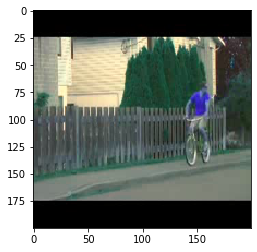

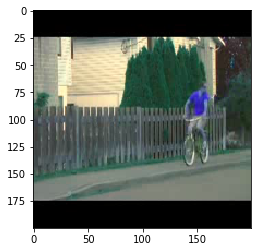

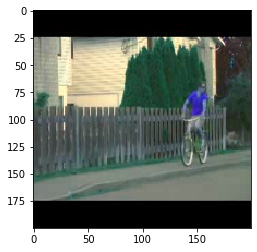

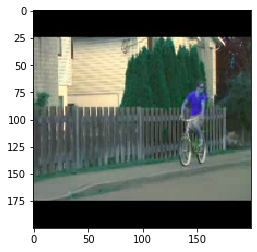

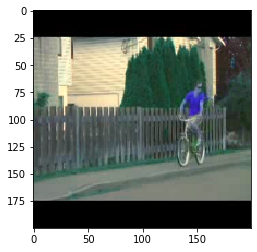

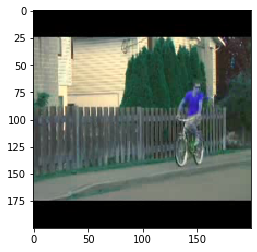

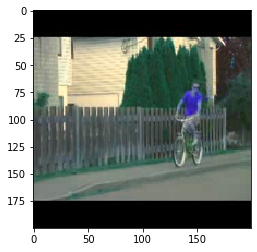

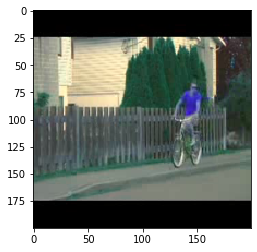

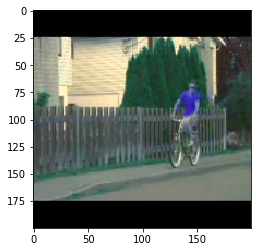

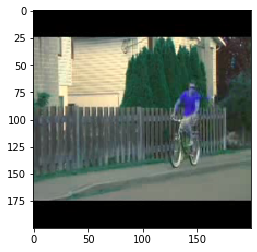

In [ ]:
# show sample video
i = 0
video = x_train[i]
cls_id = np.argmax(y_train[i])
cls_names[cls_id]
for frame in video[:10]:
    plt.imshow(frame)
    plt.show()

#### Build model

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 30, 200, 200, 3)   0         
_________________________________________________________________
time_distributed_7 (TimeDist (None, 30, 198, 198, 16)  448       
_________________________________________________________________
time_distributed_8 (TimeDist (None, 30, 99, 99, 16)    0         
_________________________________________________________________
time_distributed_9 (TimeDist (None, 30, 16)            0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 50)                13400     
_________________________________________________________________
dense_5 (Dense)              (None, 128)               6528      
_________________________________________________________________
dense_6 (Dense)              (None, 3)                 387 

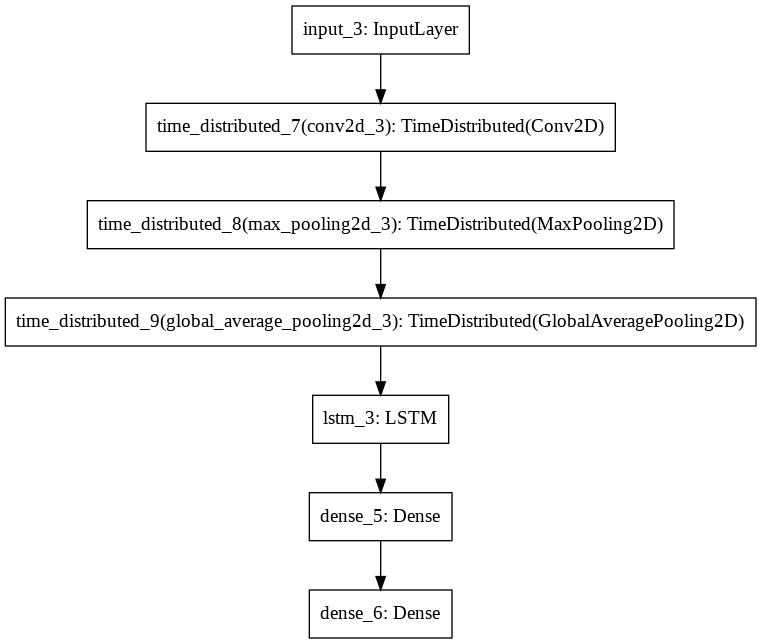

In [ ]:
# model 1: simple CNN-LSTM
inputs = Input((FRAME_SIZE, IMG_SIZE, IMG_SIZE, 3))
x = TimeDistributed(Conv2D(16, (3, 3), activation= 'relu' ))(inputs)
x = TimeDistributed(MaxPooling2D(pool_size=(2, 2)))(x)
x = TimeDistributed(GlobalAveragePooling2D())(x) # or Flatten
x = LSTM(50)(x)
x = Dense(128, activation='relu')(x)
x = Dense(len(cls_map), activation='softmax')(x)
model = Model(inputs, x)
model.summary()
plot_model(model)














Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 30, 128, 128, 3)   0         
_________________________________________________________________
time_distributed_1 (TimeDist (None, 30, 2048)          21802784  
_________________________________________________________________
lstm_1 (LSTM)                (None, 50)                419800    
_________________________________________________________________
dense_1 (Dense)              (None, 128)               6528      
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 387       
Total params: 22,229,499
Trainable params: 426,715
Non-trainable params: 21,802,784
_________________________________________________________________


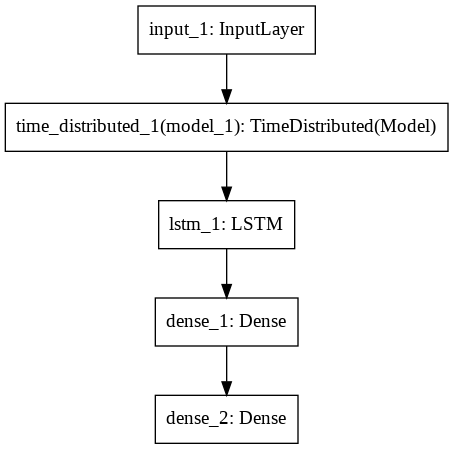

In [ ]:
# model 2: pretrained_CNN + LSTM
inputs = Input(shape = (FRAME_SIZE, IMG_SIZE, IMG_SIZE, 3))
base_model = keras.applications.inception_v3.InceptionV3(include_top = False, weights='imagenet', input_shape = (IMG_SIZE, IMG_SIZE, 3))

features = GlobalAveragePooling2D()(base_model.output) # or Flatten
cnn = Model(inputs=base_model.input, outputs=features)

encoded_frames = TimeDistributed(cnn)(inputs)
encoded_sequence = LSTM(50)(encoded_frames)

hidden_layer = Dense(128, activation="relu")(encoded_sequence)
outputs = Dense(len(cls_map), activation="softmax")(hidden_layer)
model = Model(inputs, outputs)

# freeze CNN(encoder)
for layer in base_model.layers:
    layer.trainable = False

model.summary()
plot_model(model)

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 30, 200, 200, 3)   0         
_________________________________________________________________
conv3d_4 (Conv3D)            (None, 30, 200, 200, 64)  5248      
_________________________________________________________________
max_pooling3d_4 (MaxPooling3 (None, 15, 100, 100, 64)  0         
_________________________________________________________________
conv3d_5 (Conv3D)            (None, 15, 100, 100, 128) 221312    
_________________________________________________________________
max_pooling3d_5 (MaxPooling3 (None, 7, 50, 50, 128)    0         
_________________________________________________________________
conv3d_6 (Conv3D)            (None, 7, 50, 50, 256)    884992    
_________________________________________________________________
max_pooling3d_6 (MaxPooling3 (None, 3, 25, 25, 256)    0   

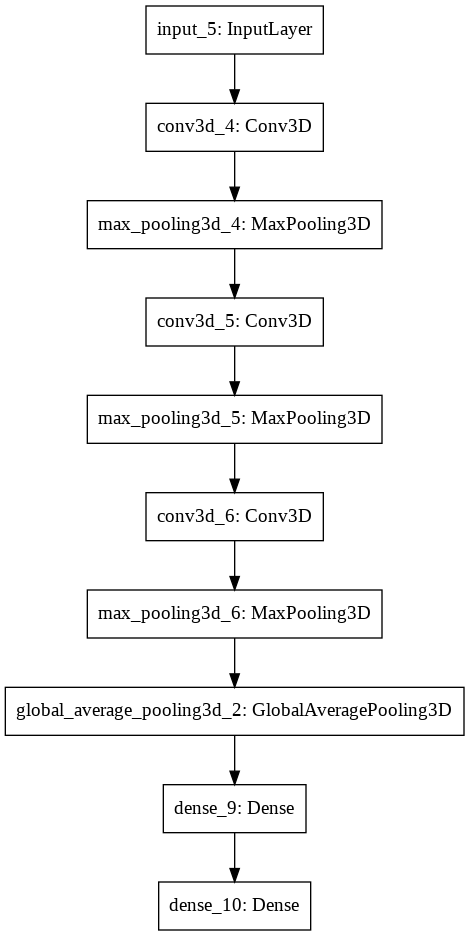

In [ ]:
# model 3: Conv3D
inputs = Input((FRAME_SIZE, IMG_SIZE, IMG_SIZE, 3))
x = Conv3D(64, (3, 3, 3), activation="relu", strides=(1, 1, 1), padding="same")(inputs)
x = MaxPooling3D(pool_size=(2, 2, 2), strides=(2, 2, 2))(x)
x = Conv3D(128, (3, 3, 3), activation="relu", strides=(1, 1, 1), padding="same")(x)
x = MaxPooling3D(pool_size=(2, 2, 2), strides=(2, 2, 2))(x)
x = Conv3D(256, (3, 3, 3), activation="relu", strides=(1, 1, 1), padding="same")(x)
x = MaxPooling3D(pool_size=(2, 2, 2), strides=(2, 2, 2))(x)
x = GlobalAveragePooling3D()(x)
x = Dense(128, activation='relu')(x)
x = Dense(len(cls_map), activation='softmax')(x)
model = Model(inputs, x)
model.summary()
plot_model(model)

In [ ]:
model.compile(loss = 'categorical_crossentropy' , optimizer = 'adam' , metrics = ['acc'])

In [ ]:
ckp = ModelCheckpoint('/content/drive/My Drive/video_classification.h5', save_best_only=True, save_weights_only=False)
early = EarlyStopping(patience=5)
model.fit(x_train, y_train, 
          epochs=100,
          batch_size=16, 
          callbacks=[ckp, early],
          validation_data=(x_test, y_test))

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 371 samples, validate on 42 samples
Epoch 1/100
371/371 [==============================] - 26s 71ms/step - loss: 1.1216 - acc: 0.3261 - val_loss: 1.0816 - val_acc: 0.4048
Epoch 2/100
371/371 [==============================] - 9s 24ms/step - loss: 1.0488 - acc: 0.4555 - val_loss: 0.9532 - val_acc: 0.6905
Epoch 3/100
371/371 [==============================] - 9s 23ms/step - loss: 0.8487 - acc: 0.7170 - val_loss: 0.7314 - val_acc: 0.7381
Epoch 4/100
371/371 [==============================] - 9s 24ms/step - loss: 0.5470 - acc: 0.8329 - val_loss: 0.5079 - val_acc: 0.8095
Epoch 5/100
371/371 [==============================] - 9s 24ms/step - loss: 0.2609 - acc: 0.9245 - val_loss: 0.3914 - val_acc: 0.8571
Epoch 6/100
371/371 [==============================] - 9s 24ms/step - loss: 0.1460 - acc: 0.9623 - val_loss: 0.4136 - val_acc: 0.8333
Epoch 7/100
371/371 [==============================] -